Segmentation
=======

In [1]:
%matplotlib inline

import cv2
import numpy as np
from matplotlib import pyplot as plt

from skimage import data, segmentation, color
from skimage.future import graph
from skimage.transform import rescale, resize, downscale_local_mean

from mean_shift.mean_shift_utils import *
from mean_shift.mean_shift import *

Original image
----------------

(259, 387, 3)

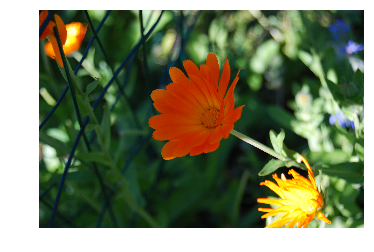

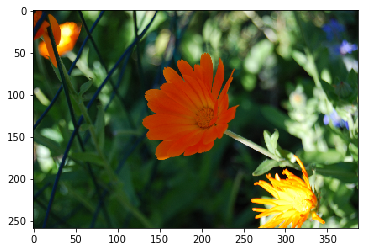

In [16]:
orig_img = plt.imread('data/DSC_0066.JPG')
plt.imshow(orig_img)
plt.axis('off')

resized_img = 255 * resize(orig_img, (orig_img.shape[0] / 10, orig_img.shape[1] / 10))
img = resized_img.astype(np.uint8)

plt.figure()
plt.imshow(img)

img.shape

Segmentation based on Mean shift
-----------------------------------

The kernel for segmentation
$$K_{h_s, h_r}(\mathbf{x}) = \frac{C}{{h^2_s} {h^p_r}}k(\|\frac{\mathbf{x}^s}{h_s}\|^2)k(\|\frac{\mathbf{x}^r}{h_r}\|^2)$$

In [17]:
a = convert_img_vec(img)

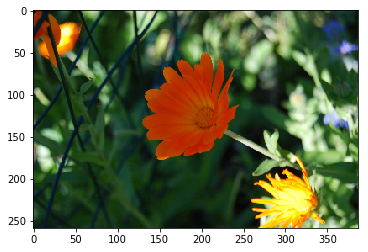

In [18]:
def vec2img(vec, shape):
    l, w = shape
    img_o = np.array(vec)
    img_info = img_o[:, 2:]
    c = img_info.reshape(l, w, 3)
    cc = np.array(c, dtype='uint8')
    im = cv2.cvtColor(cc, cv2.COLOR_Luv2RGB)
    
    return im

## Demo
plt.imshow(vec2img(a, img.shape[:2]))

In [ ]:
ms = mean_shift(kernel=segmentation_kernel)
immm = ms.cluster(a, (4, 16))

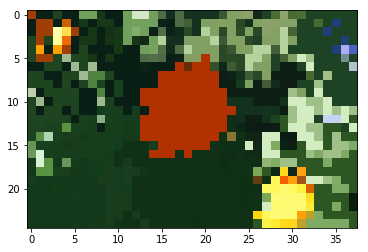

In [15]:
re = vec2img(immm, img.shape[:2])
plt.imshow(re)

In [ ]:
immm = []
for i in kmeans.labels_:
    immm.append(kmeans.cluster_centers_[i])

In [ ]:
len(immm)f

Segmentation based on Normalized Cut
----------------------------------------

In [ ]:
labels1 = segmentation.slic(img, compactness=30, n_segments=100)
g = graph.rag_mean_color(img, labels1, mode='similarity')
labels2 = graph.cut_normalized(labels1, g)
out = color.label2rgb(labels2, img, kind='avg')
plt.imshow(out)

In [ ]:
g.node[0]